# Calculate the letter 2-grams for a piece of text

Exercise 8.5.1 in the Oxford ML course.

The example text is from *Little Woman*, by Louisa May Alcott.

## Exercise 1

### Data structures

We setup the data structures that we want to use. The first will count the number of occurrences of individual letters. The second will count the number of occurrences of letter pairs αβ.

In [1]:
a2z = Vector{Char}(collect('a':'z'));
rangea2z = 1:26;
single_counts = Dict{Char,Int}();
double_counts = Dict{Tuple{Char,Char},Int}();
for c in a2z
    single_counts[c] = 0;
    for d in a2z
        double_counts[(c,d)] = 0;
    end
end

### Target text

We define the input text, then clean it up by converting everything to lower case characters and ignoring all punctuation and spaces - we obtain a very long lower case text sequence.

In [2]:
original_text = """
"Christmas won't be Christmas without any presents," grumbled Jo, lying
on the rug.

"It's so dreadful to be poor!" sighed Meg, looking down at her old
dress.

"I don't think it's fair for some girls to have plenty of pretty
things, and other girls nothing at all," added little Amy, with an
injured sniff.

"We've got Father and Mother, and each other," said Beth contentedly
from her corner.

The four young faces on which the firelight shone brightened at the
cheerful words, but darkened again as Jo said sadly, "We haven't got
Father, and shall not have him for a long time." She didn't say
"perhaps never," but each silently added it, thinking of Father far
away, where the fighting was.

Nobody spoke for a minute; then Meg said in an altered tone, "You know
the reason Mother proposed not having any presents this Christmas was
because it is going to be a hard winter for everyone; and she thinks we
ought not to spend money for pleasure, when our men are suffering so in
the army.  We can't do much, but we can make our little sacrifices, and
ought to do it gladly.  But I am afraid I don't," and Meg shook her
head, as she thought regretfully of all the pretty things she wanted.
"""
lc_text = lowercase(original_text);
clean_text = replace(lc_text, r"[^a-z]" => "")

"christmaswontbechristmaswithoutanypresentsgrumbledjolyingontherugitssodreadfultobepoorsighedmeglookingdownatherolddressidontthinkitsfairforsomegirlstohaveplentyofprettythingsandothergirlsnothingatalladdedlittleamywithaninjuredsniffwevegotfatherandmotherandeachothersaidbe" ⋯ 371 bytes ⋯ "becauseitisgoingtobeahardwinterforeveryoneandshethinksweoughtnottospendmoneyforpleasurewhenourmenaresufferingsointhearmywecantdomuchbutwecanmakeourlittlesacrificesandoughttodoitgladlybutiamafraididontandmegshookherheadasshethoughtregretfullyofalltheprettythingsshewanted"

### Analysis

Now walk through the text and count each character, and each character pairing

In [3]:
for (i, c) in enumerate(clean_text)
    single_counts[c] += 1;
    if i < length(clean_text)
        next_c = clean_text[i+1];
        double_counts[(c,next_c)] += 1;
    end
end

In [4]:
single_counts

Dict{Char, Int64} with 26 entries:
  'n' => 69
  'f' => 27
  'w' => 19
  'd' => 45
  'e' => 104
  'o' => 69
  'h' => 63
  'j' => 3
  'i' => 56
  'k' => 9
  'r' => 60
  's' => 55
  't' => 86
  'q' => 0
  'y' => 20
  'a' => 71
  'c' => 16
  'p' => 13
  'm' => 21
  ⋮   => ⋮

### Answers (part 1)

In [5]:
"""
    two_gram_probability(β::Char, α::Char)

Calculate the probability of the letter `β` following the letter `α` in the text.
"""
function two_gram_probability(β::Char, α::Char)
    if single_counts[α] == 0
        return 0.0
    end
    return double_counts[(α,β)] / single_counts[α]
end

two_gram_probability

In [6]:
for pairs in [('c', 't'), ('h', 't'), ('t', 't')]
    println("P($(pairs[1]) | $(pairs[2])) = $(two_gram_probability(pairs[1], pairs[2]))")
end

P(c | t) = 0.0
P(h | t) = 0.3488372093023256
P(t | t) = 0.10465116279069768


### Bonus content

Make some plots of the distributions

In [7]:
using CairoMakie

Plot counts for each letter

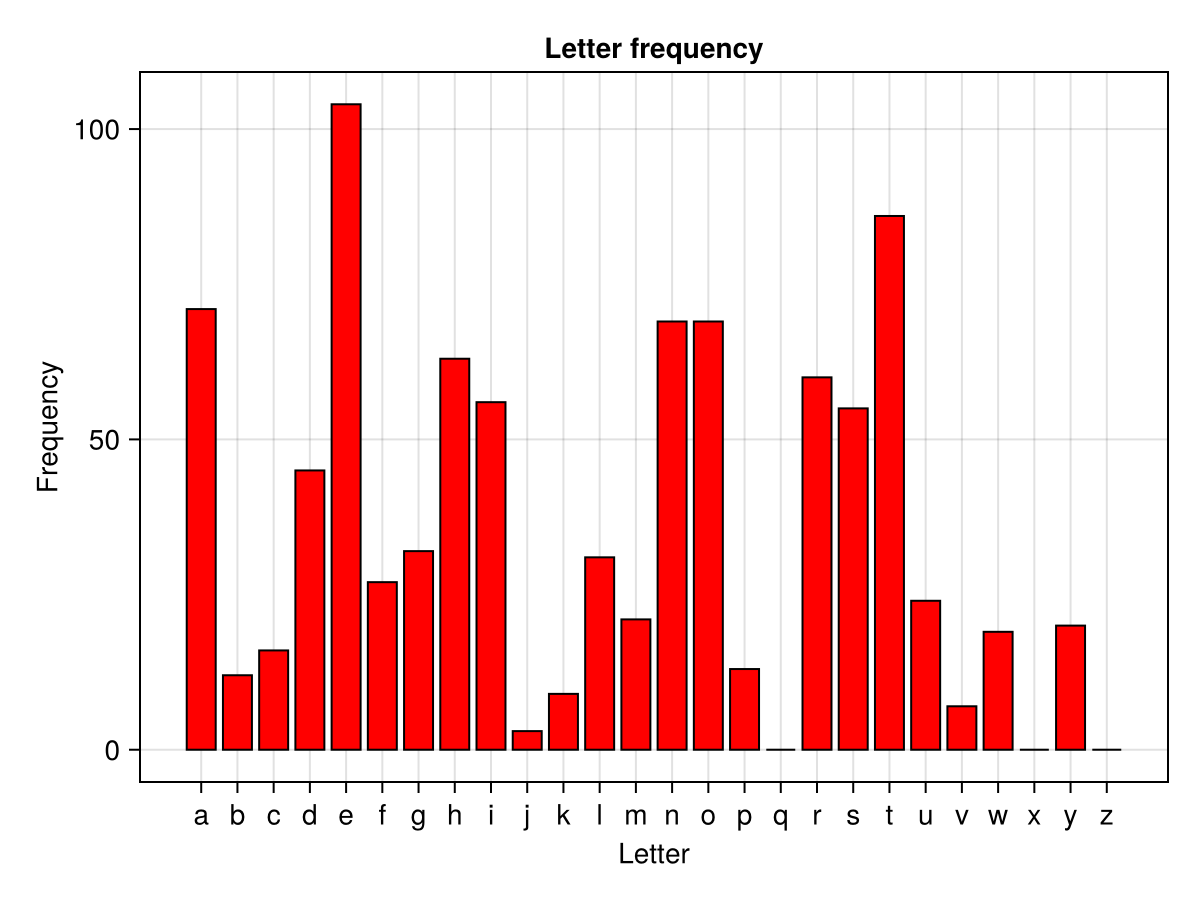

In [8]:
barplot(rangea2z, [ single_counts[c] for c in a2z ]; 
    axis =(
        title = "Letter frequency",
        xlabel = "Letter",
        ylabel = "Frequency",
        xticks = (1:26, [string(l) for l in a2z])),
        color = :red, strokecolor = :black, strokewidth = 1
)

How many letters don't appear at all?

In [9]:
println("$(sum(values(single_counts) .== 0)) letters don't appear at all in the text.")
for (l, v) in single_counts
    if v == 0
        println("Letter $(l) does not appear in the text.")
    end
end

3 letters don't appear at all in the text.
Letter q does not appear in the text.
Letter z does not appear in the text.
Letter x does not appear in the text.


Now plot the 2D pairings

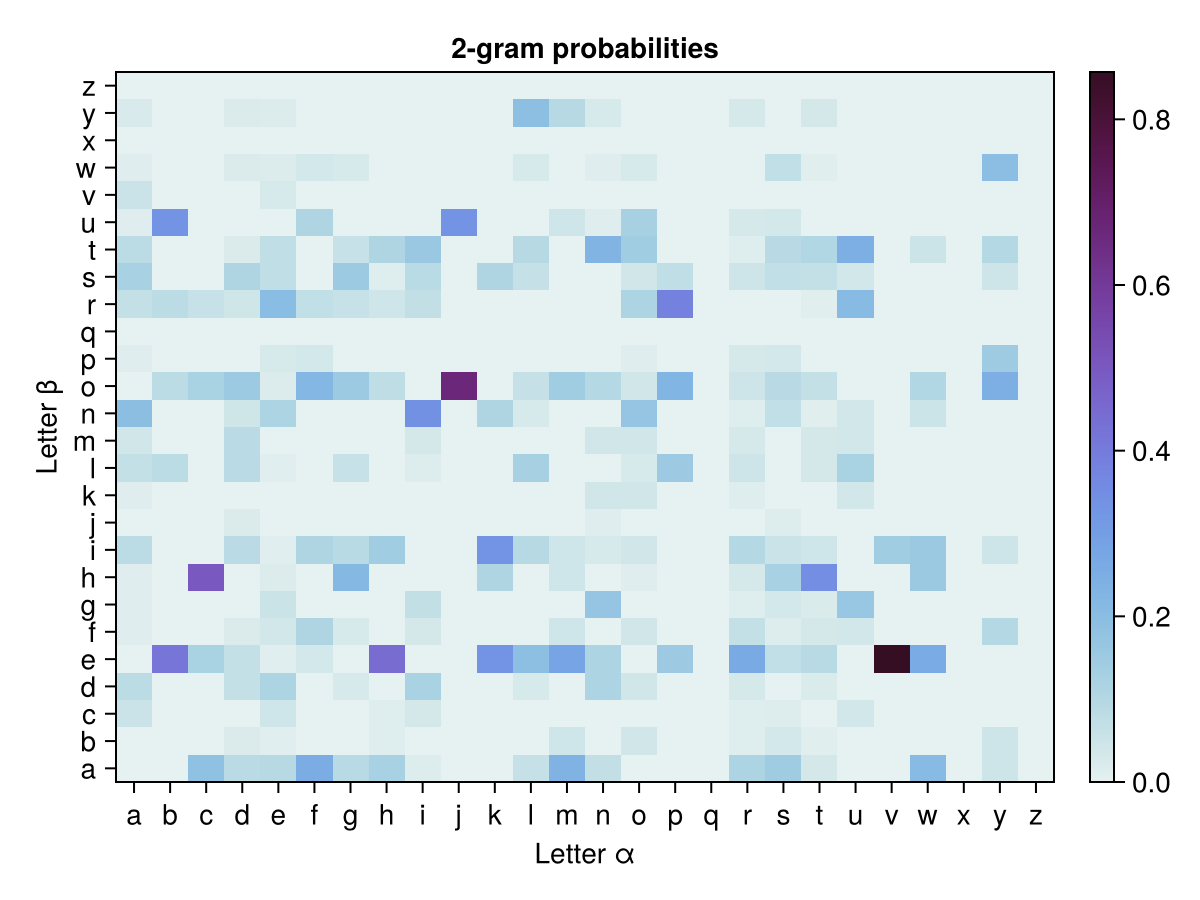

In [10]:
fig, ax, hm = heatmap(rangea2z, rangea2z, [ two_gram_probability(a2z[j], a2z[i]) for i in rangea2z, j in rangea2z ];
    axis = (
        title = "2-gram probabilities",
        xlabel = "Letter α",
        ylabel = "Letter β",
        xticks = (rangea2z, [string(l) for l in a2z]),
        yticks = (rangea2z, [string(l) for l in a2z])
    ),
    colormap = :dense
)
Colorbar(fig[:, end+1], hm)
fig

How many pairings are missing?

In [11]:
missing_pairings = sum(values(double_counts) .== 0)
total_pairings = length(double_counts)
println("There are $(missing_pairings) missing pairings out of $(total_pairings) total pairings ($(missing_pairings/total_pairings)).")

There are 432 missing pairings out of 676 total pairings (0.6390532544378699).


## Exercise 2

Recompute the n-gram, but with smoothing, that is

$$
Pr(x_2 = \beta, x_1 = \alpha) = \frac{\# (x_1 = \alpha \; \mathrm{AND} \; x_2 = \beta) + 1}{\# (x_1 = \alpha) + |V|}
$$

The counts remain the same as in the first exercise, we just define a new function that gives the smoothed probability

In [12]:
"""
    smoothed_two_gram_probability(β::Char, α::Char)

Calculate the smoothed probability of the letter `β` following the letter `α` in the text.
"""
function smoothed_two_gram_probability(β::Char, α::Char)
    return (double_counts[(α,β)] + 1) / (single_counts[α] + length(single_counts))
end

smoothed_two_gram_probability

### Answer (part 2)

In [13]:
for pairs in [('c', 't'), ('h', 't'), ('t', 't')]
    println("Pr($(pairs[1]) | $(pairs[2])) = $(smoothed_two_gram_probability(pairs[1], pairs[2]))")
end

Pr(c | t) = 0.008928571428571428
Pr(h | t) = 0.2767857142857143
Pr(t | t) = 0.08928571428571429


With smoothing the zero probability values have disappeared and higher values are reduced

### Smoothed Distribution Heatmap

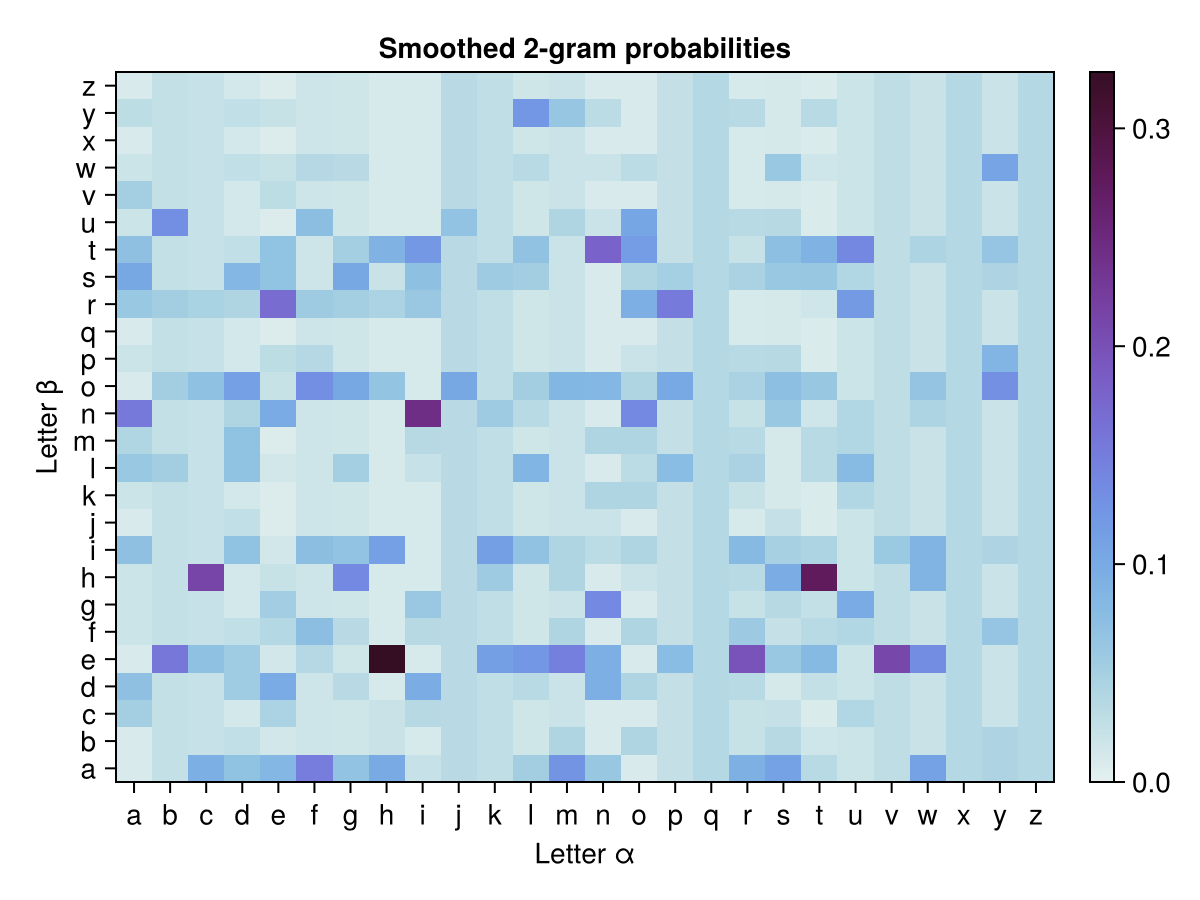

In [14]:
fig, ax, hm = heatmap(rangea2z, rangea2z, [ smoothed_two_gram_probability(a2z[j], a2z[i]) for i in rangea2z, j in rangea2z ];
    axis = (
        title = "Smoothed 2-gram probabilities",
        xlabel = "Letter α",
        ylabel = "Letter β",
        xticks = (rangea2z, [string(l) for l in a2z]),
        yticks = (rangea2z, [string(l) for l in a2z])
    ),
    colorrange = (0.0, maximum([ smoothed_two_gram_probability(a2z[j], a2z[i]) for i in rangea2z, j in rangea2z ])),
    colormap = :dense
)
Colorbar(fig[:, end+1], hm)
fig